In [17]:
from imu.raw_dataset import IMUHumanEventDatabase

# - Data processing
import numpy as np

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

# - Import modules
from rockpool.devices.xylo.imu.preprocessing import Quantizer, JSVD, RotationLookUpTable

# Get the data

In [18]:
imu_db = IMUHumanEventDatabase(device_id="00")
train_set = imu_db.train_set
val_set = imu_db.val_set
test_set = imu_db.test_set

## Plot some raw samples

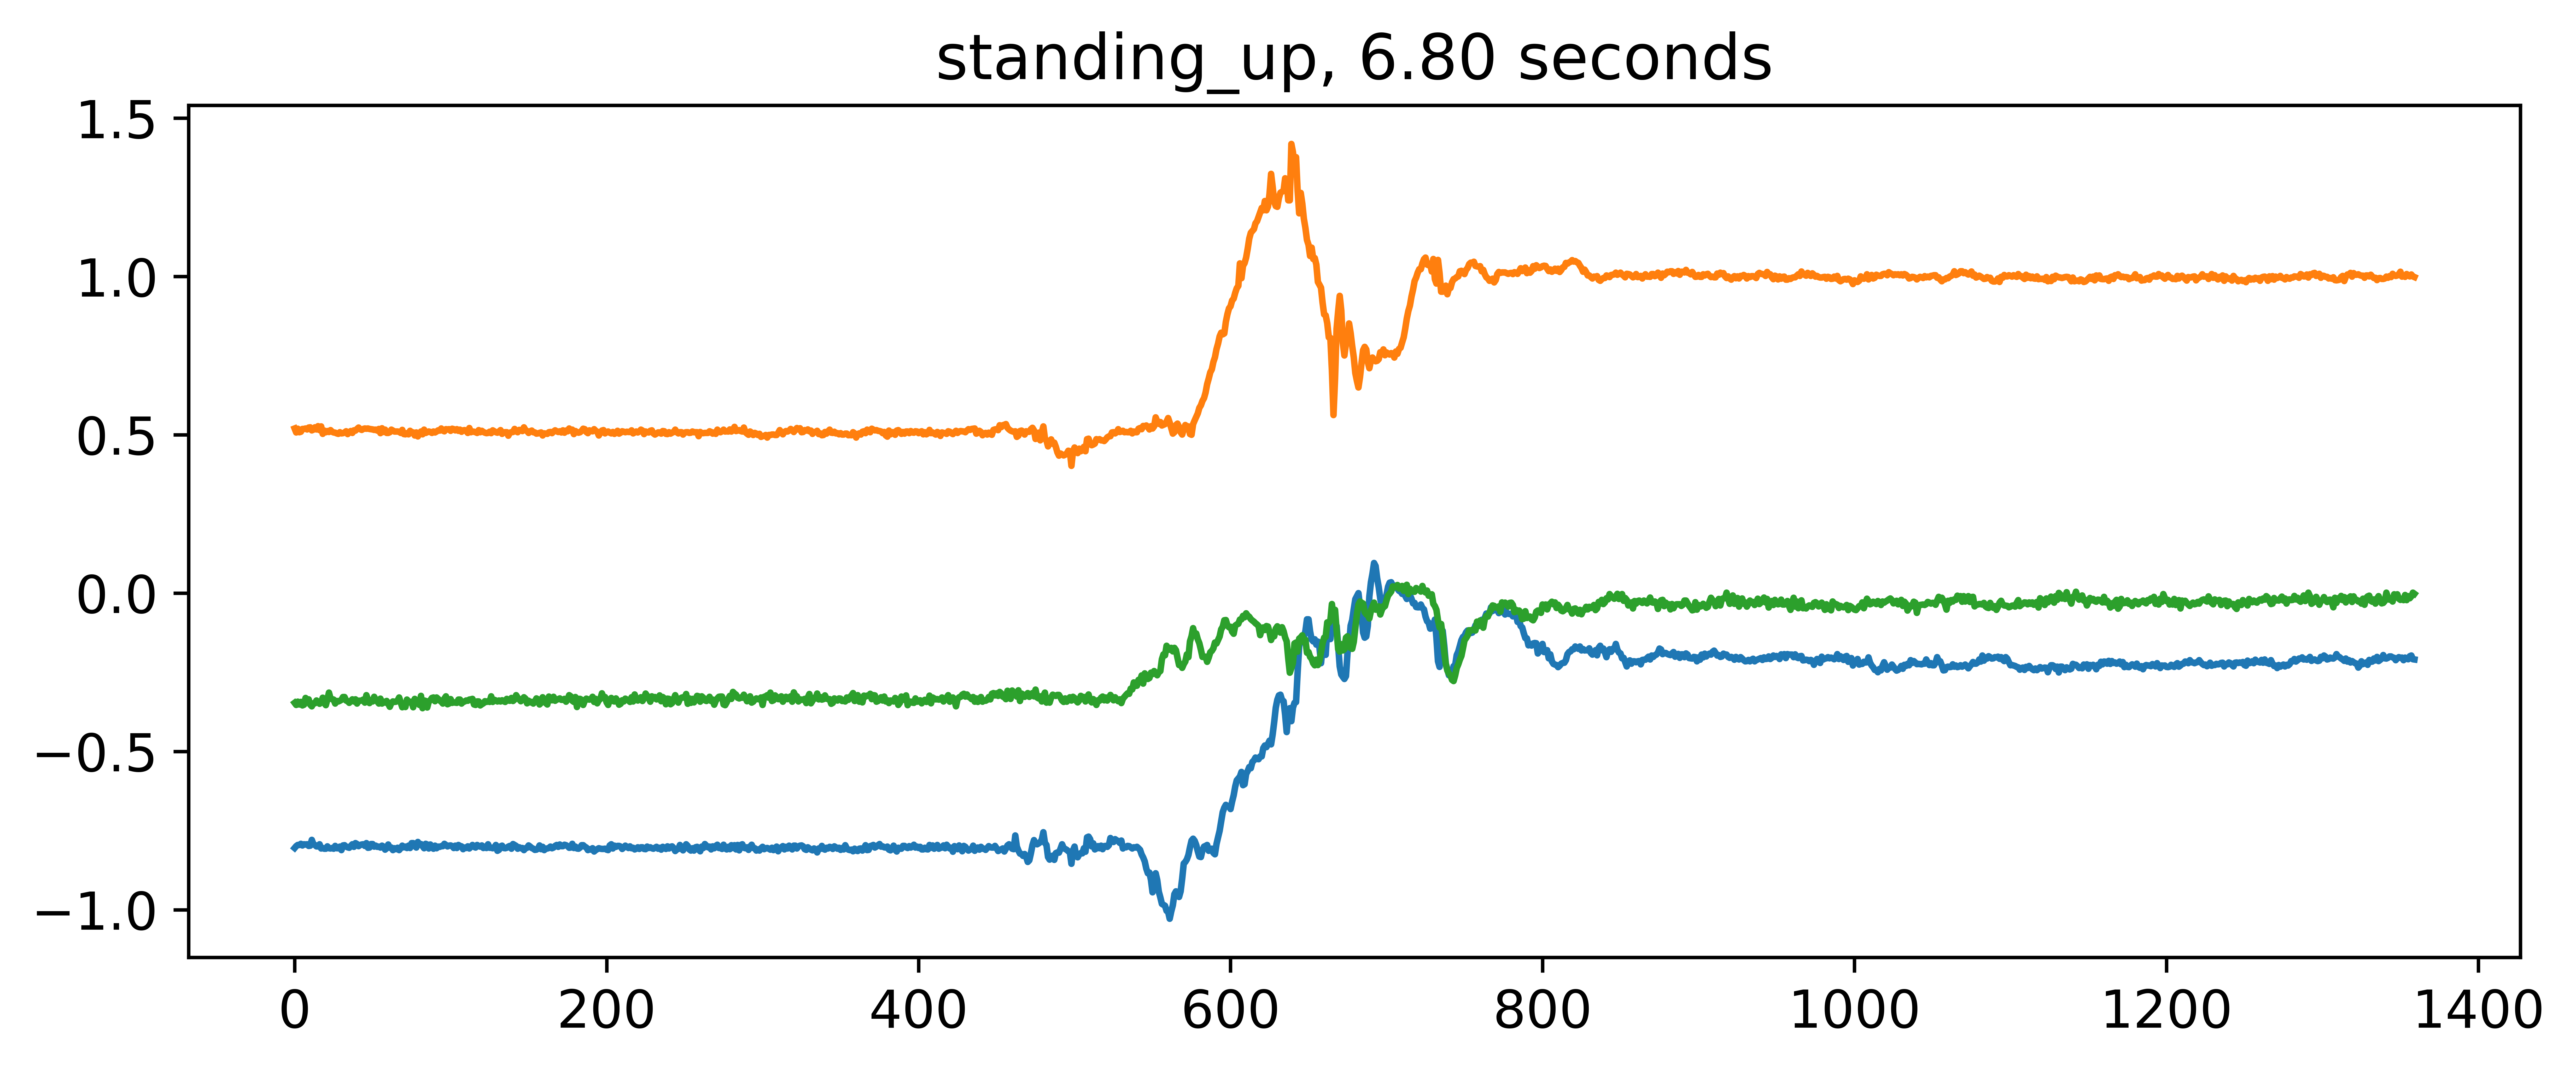

In [19]:
data, label, duration = train_set[0]
reverse_map = {v:k for k,v in train_set.label_map.items()}
plt.figure()
plt.plot(data)
plt.title(f"{reverse_map[label]}, {duration:.2f} seconds")
plt.show()

In [20]:
data.shape

(1360, 3)

## Step 1 : Quantize the data

Scale is obtained by investigating the dataset statistics. The maximum amplitude = 1.0 using scale factor=`0.49`

In [21]:
quantizer = Quantizer(shape=3, scale=0.49, num_bits=16)

In [22]:
data_quantized, _, _ = quantizer(data)

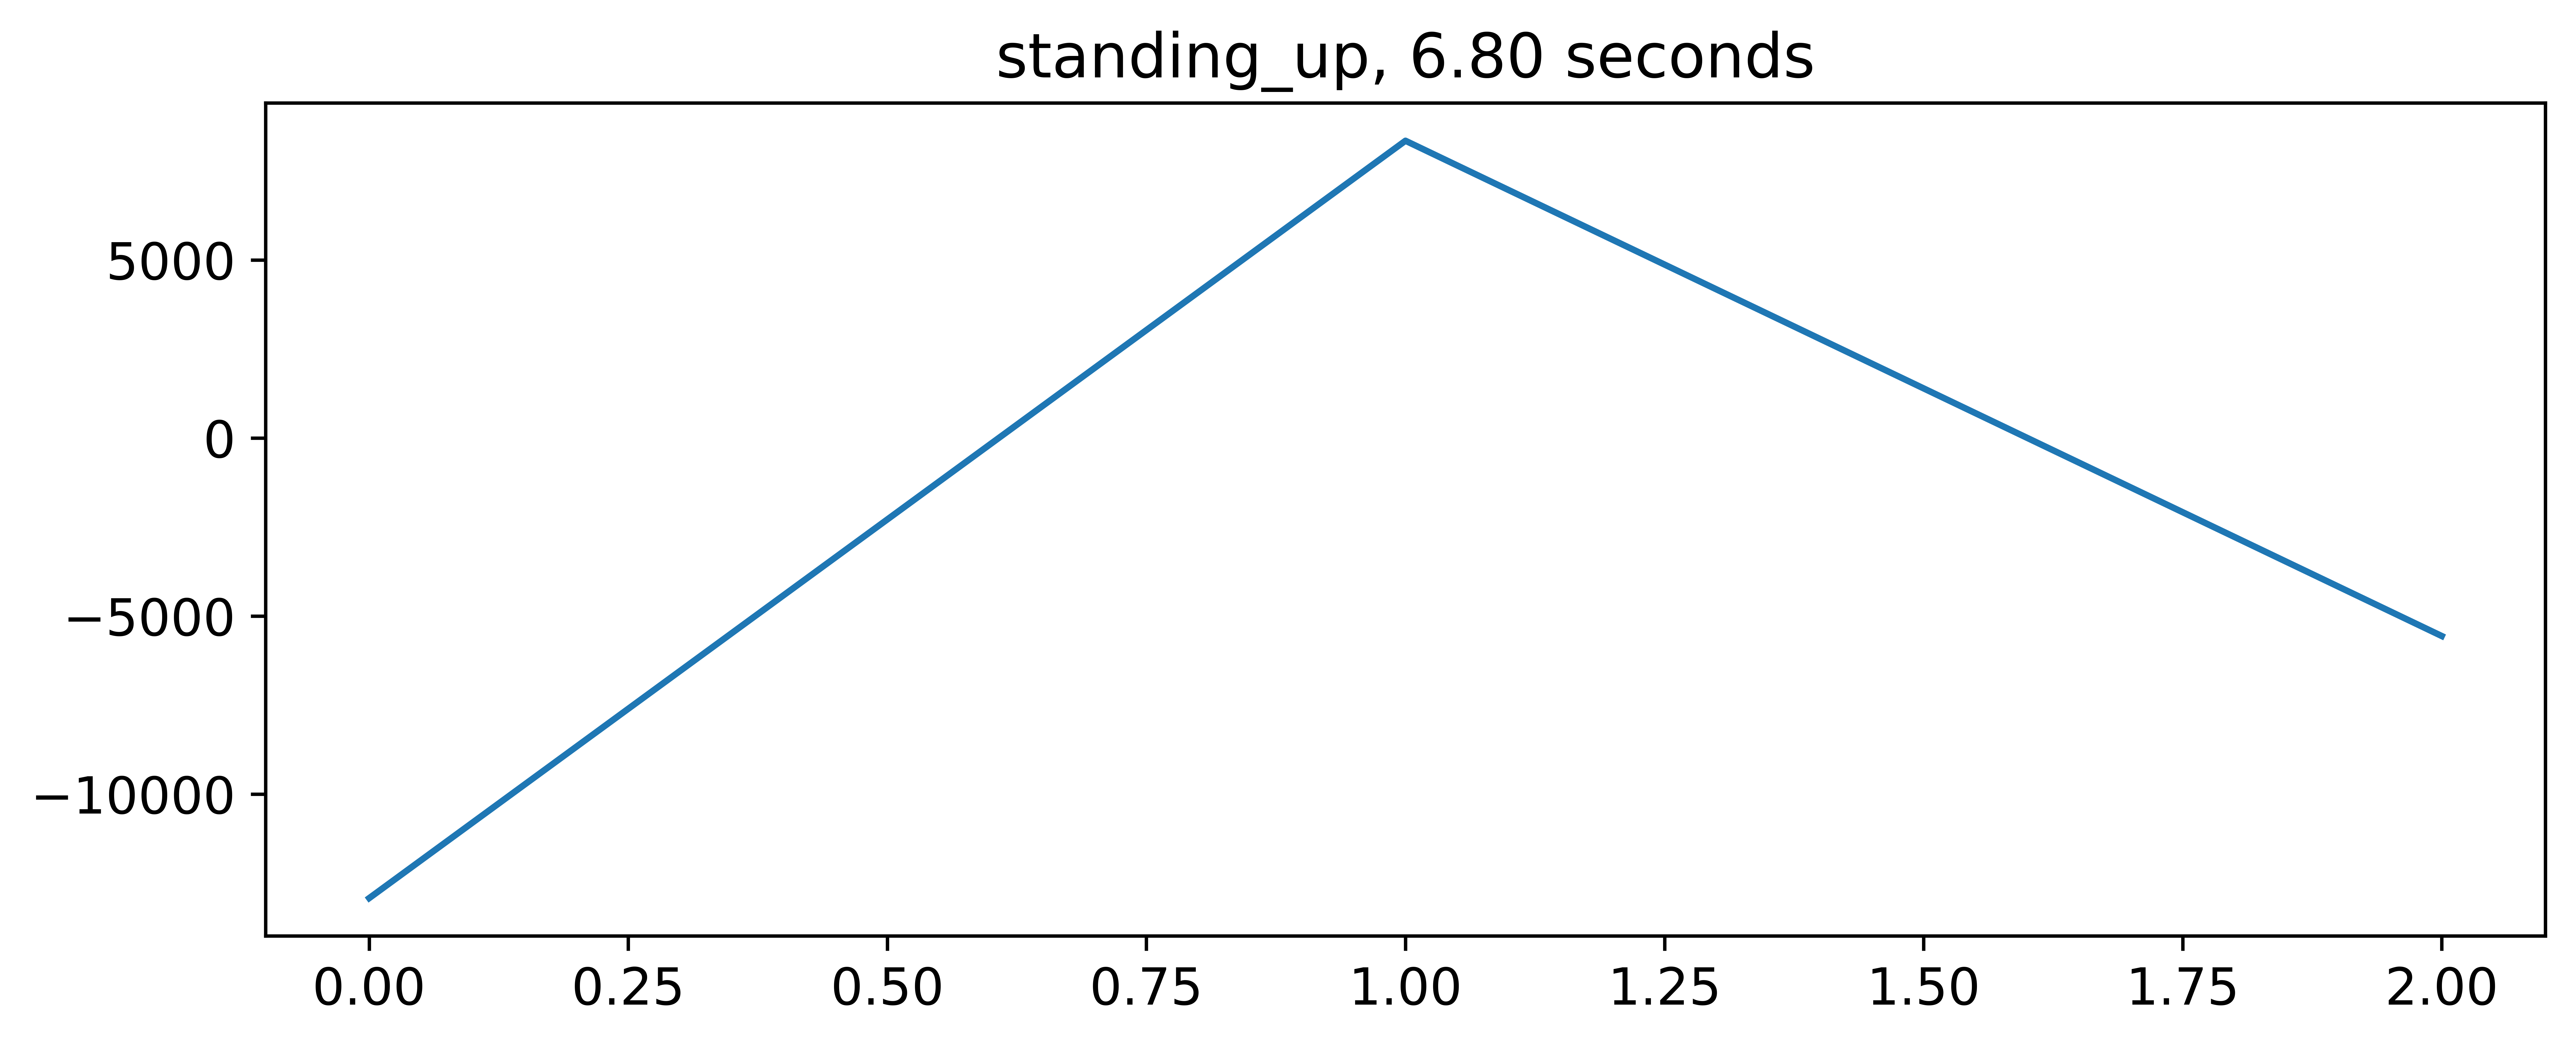

In [23]:
plt.figure()
plt.plot(data_quantized[0])
plt.title(f"{reverse_map[label]}, {duration:.2f} seconds")
plt.show()

## Step 2 : Subspace Estimation

## Step 3 : JSVD

In [24]:
jsvd = JSVD(
    lookuptable=RotationLookUpTable(num_angles=64, num_bits=16),
    num_bits_covariance=32,
    num_bits_rotation=32,
    nround=4,
)

WARNING    /home/ugurcan/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/imu/preprocessing/lookup.py:91: RuntimeWarning: divide by zero encountered in divide
  self.cot2_vals = 1 / np.tan(2 * self.angles_radian)
 [py.warnings]


In [25]:
# jsvd()